<a href="https://colab.research.google.com/github/Michele-Simeone/AILabProj-NBA-Scheme-Classification/blob/main/Code/Neural_Network_NBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import**

### **Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Altri Import**

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten,MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

# **Dataset**

## **Caricamento Dataset**

In [3]:
train_dir="/content/drive/MyDrive/LabIA/Dataset/CNN/Train"
test_dir="/content/drive/MyDrive/LabIA/Dataset/CNN/Test"

#train_dir="/content/drive/MyDrive/LabIA/CNN/Train"
#test_dir="/content/drive/MyDrive/LabIA/CNN/Test"

batch_dim=8


train_generator = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        image_size=(256, 256),  
        batch_size=batch_dim,
        label_mode='int',
        seed=297,
        subset='training')

validation_generator =  tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        image_size=(256, 256),
        batch_size=batch_dim,
        label_mode='int',
        seed=297,
        subset='validation')

test_generator =  tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(256, 256),
        batch_size=batch_dim,
        label_mode='int')

Found 567 files belonging to 2 classes.
Using 454 files for training.
Found 567 files belonging to 2 classes.
Using 113 files for validation.
Found 180 files belonging to 2 classes.


### **Plot Dataset**

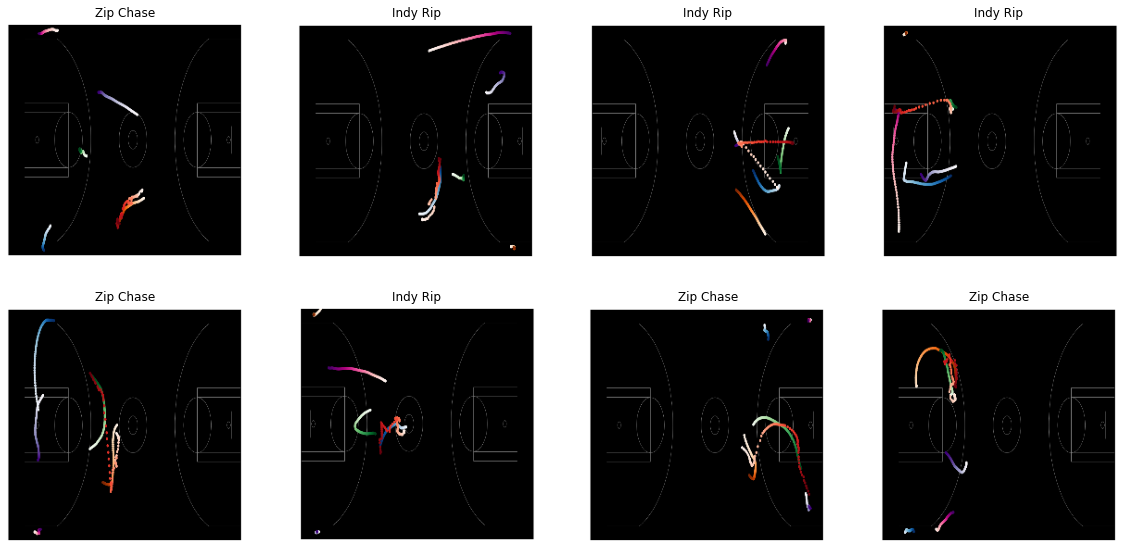

In [4]:
plt.figure(figsize=(20, 20))
for images, labels in train_generator.take(1):
  for i in range(8): 
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_generator.class_names[labels[i]])
    plt.axis("off")

### **Operazioni per Ottimizzazione della Memoria**

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)


## **Funzione per disegnare le Learning Curves**

In [6]:
def learning_curves(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']


  loss = history.history['loss']
  val_loss = history.history['val_loss']


  epochs = range(len(acc))


  plt.plot(epochs, acc,"tab:green", label="Training")
  plt.plot(epochs, val_acc,"tab:blue", label="Validation")
  plt.legend(loc="upper left")
  plt.title('Training and validation accuracy')

  plt.figure()


  plt.plot(epochs, loss,"tab:green", label="Training")
  plt.plot(epochs, val_loss,"tab:blue", label="Validation")
  plt.legend(loc="upper right")
  plt.title('Training and validation loss')


# **CNN**

## **Model**

In [13]:
# 256x256 per i pixels dell'immagine, and 3 per i canali
i_input = layers.Input(shape=(256, 256, 3))

#x=layers.Rescaling(1./255, input_shape=(256, 256, 3))(i_input)

# Estrazione di 16 filtri 3x3, poi Max-Pool con una finestra 2x2
x = layers.Conv2D(16, 3, activation='relu')(i_input)
x = layers.MaxPooling2D(2)(x)

# Estrazione di 32 filtri 3x3,  poi Max-Pool con una finestra 2x2
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Estrazione di 64 filtri 3x3,  poi Max-Pool con una finestra 2x2
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

# Estrazione di 128 filtri 3x3,  poi Max-Pool con una finestra 2x2
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

# Flatten della feature map a un tensore ad una dim così creiamo un full-connected layer
x = layers.Flatten()(x)

# Creazione di un fully-connected layer con ReLU e 512 unità hidden 
x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
# Creazione di un layer output con sigmoide
output = layers.Dense(1, activation='sigmoid')(x)


model = Model(i_input, output)


model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1849

## **Compilazione**

In [14]:
lr=0.001

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=lr),
              metrics=['acc'])

## **Train**

In [15]:
epoche=50
es=EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)
mc=ModelCheckpoint('/content/drive/MyDrive/LabIA/Best Model/best_model1.h5', monitor='val_accuracy', mode='max')
with tf.device('/gpu:0'):
  history = model.fit(
        train_generator,
        epochs=epoche,
        validation_data=validation_generator,
        callbacks=[mc,es])

Epoch 1/50
57/57 [==============================] - 6s 63ms/step - loss: 1.0160 - acc: 0.5551 - val_loss: 4.2290 - val_acc: 0.5841
Epoch 2/50
57/57 [==============================] - 2s 27ms/step - loss: 0.7841 - acc: 0.5837 - val_loss: 1.0959 - val_acc: 0.5752
Epoch 3/50
57/57 [==============================] - 2s 26ms/step - loss: 0.5865 - acc: 0.7225 - val_loss: 0.8328 - val_acc: 0.6549
Epoch 4/50
57/57 [==============================] - 2s 27ms/step - loss: 0.3285 - acc: 0.8480 - val_loss: 1.3062 - val_acc: 0.6903
Epoch 5/50
57/57 [==============================] - 1s 26ms/step - loss: 0.1892 - acc: 0.9163 - val_loss: 0.4986 - val_acc: 0.8053
Epoch 6/50
57/57 [==============================] - 1s 26ms/step - loss: 0.1185 - acc: 0.9559 - val_loss: 0.5160 - val_acc: 0.8142
Epoch 7/50
57/57 [==============================] - 1s 26ms/step - loss: 0.0895 - acc: 0.9670 - val_loss: 0.2482 - val_acc: 0.9115
Epoch 8/50
57/57 [==============================] - 2s 27ms/step - loss: 0.0704 - a

### **Effetto del Modello su un'Immagine disegnato**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


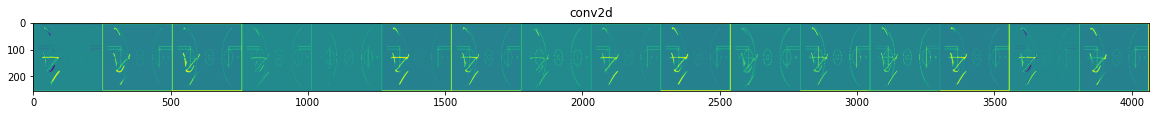

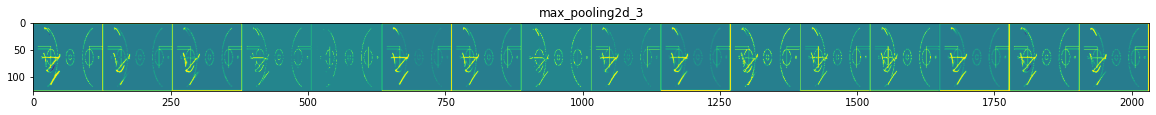

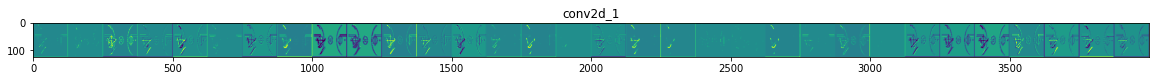

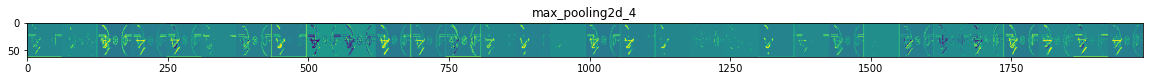

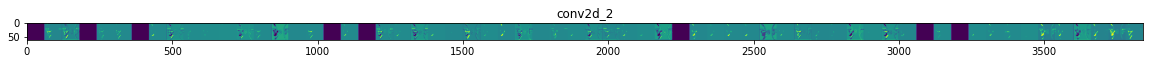

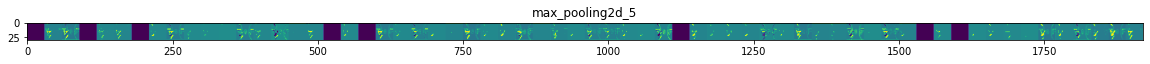

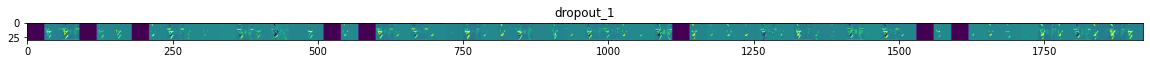

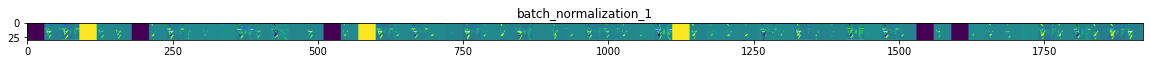

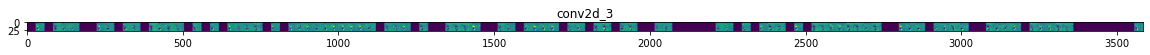

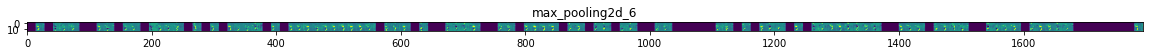

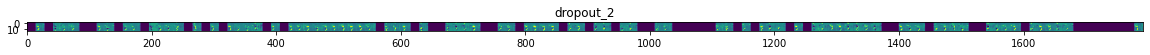

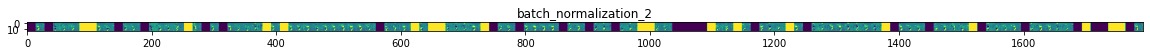

In [16]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(i_input, successive_outputs)


img_path ="/content/drive/MyDrive/LabIA/Dataset/CNN/Train/Indy Rip/12.png"
#img_path="/content/drive/MyDrive/LabIA/CNN/Test/Indy Rip/0 (1).png"


img = load_img(img_path, target_size=(256, 256))  
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  


x /= 255


successive_feature_maps = visualization_model.predict(x)


layer_names = [layer.name for layer in model.layers[1:]]


for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1] 
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### **Disegno Learning Curves**

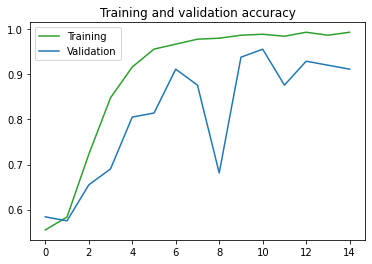

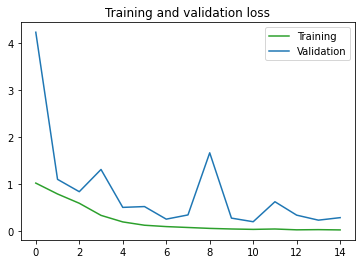

In [17]:
learning_curves(history)

### **Caricamento dei pesi su Drive**

In [18]:
model.load_weights("/content/drive/MyDrive/LabIA/Best Model/best_model1.h5")

## **Test**

In [19]:
results = model.evaluate(
      test_generator,
      batch_size=batch_dim)
print("test loss, test acc:", results)


23/23 [==============================] - 2s 50ms/step - loss: 0.9294 - acc: 0.8389
test loss, test acc: [0.9293857216835022, 0.8388888835906982]


### **Salvataggio del modello**

In [20]:
model.save("/content/drive/MyDrive/LabIA/Model/NBA_model")

## **Prediction**

### **Caricamento del modello**

In [21]:
load_model = tf.keras.models.load_model("/content/drive/MyDrive/LabIA/Model/NBA_model")

### **Plot delle prediction**

[1.4457897e-02 9.7276944e-01 9.9999964e-01 9.8021126e-01 2.0130069e-04
 9.9990034e-01 1.6238812e-01 6.5780405e-05]
Predictions: [0 1 1 1 0 1 0 0]
Real: [0 1 0 1 0 1 1 0]


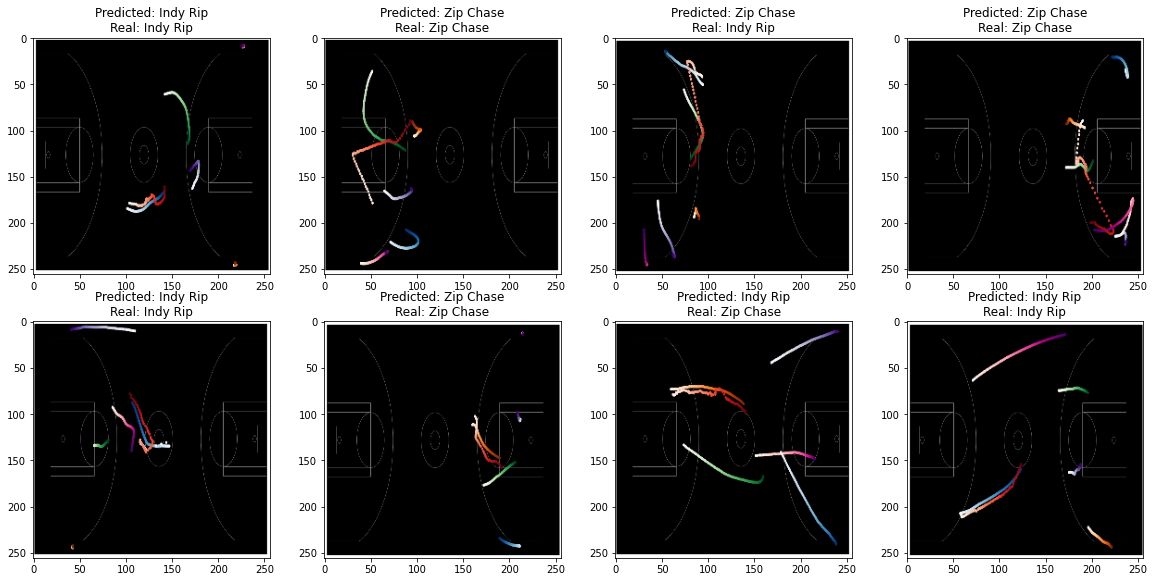

In [22]:
image_batch, label_batch = test_generator.as_numpy_iterator().next()
predictions = load_model.predict_on_batch(image_batch).flatten()

print(predictions)

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions >0.7, 1, 0)

print('Predictions:', predictions.numpy())
print('Real:', label_batch)

plt.figure(figsize=(20, 20))
for i in range(8):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("Predicted: " + test_generator.class_names[predictions[i]] + "\n" + "Real: " + test_generator.class_names[label_batch[i]])

# **SVM**

## **Model**

In [7]:
i_input = layers.Input(shape=(256, 256, 3))

x=layers.Rescaling(1./255, input_shape=(256, 256, 3))(i_input)

# Estrazione di 32 filtri 3x3, poi Max-Pool con una finestra 2x2
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPool2D(2)(x)

# Estrazione di 64 filtri 3x3,  poi Max-Pool con una finestra 2x2
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

# Estrazione di 128 filtri 3x3,  poi Max-Pool con una finestra 2x2
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

# Flatten della feature map a un tensore ad una dim così creiamo un full-connected layer
x = layers.Flatten()(x)

# Creazione di un fully-connected layer con ReLU e 512 unità hidden 
x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
# Creazione di un layer output con linear
output = layers.Dense(1, kernel_regularizer=l2(0.01),activation = "linear")(x)

model2 = Model(i_input, output)

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                         

## **Compilazione**

In [8]:
lr=0.001

model2.compile(loss='hinge',
              optimizer=Adam(learning_rate=lr),
              metrics=['acc'])

## **Train**

In [9]:
epoche=50
es=EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)
mc=ModelCheckpoint('/content/drive/MyDrive/LabIA/Best Model/best_svm_model.h5', monitor='val_accuracy', mode='max')

with tf.device('/gpu:0'):
  history2 = model2.fit(
        train_generator,
        epochs=epoche,
        validation_data=validation_generator,
        callbacks=[mc,es])

Epoch 1/50
57/57 [==============================] - 60s 433ms/step - loss: 1.2476 - acc: 0.5242 - val_loss: 0.9921 - val_acc: 0.5044
Epoch 2/50
57/57 [==============================] - 8s 134ms/step - loss: 0.7631 - acc: 0.6762 - val_loss: 0.9549 - val_acc: 0.5044
Epoch 3/50
57/57 [==============================] - 5s 83ms/step - loss: 0.4630 - acc: 0.7885 - val_loss: 0.9426 - val_acc: 0.6460
Epoch 4/50
57/57 [==============================] - 5s 83ms/step - loss: 0.2821 - acc: 0.8987 - val_loss: 1.2588 - val_acc: 0.4779
Epoch 5/50
57/57 [==============================] - 5s 87ms/step - loss: 0.3133 - acc: 0.8899 - val_loss: 1.6530 - val_acc: 0.4956
Epoch 6/50
57/57 [==============================] - 5s 85ms/step - loss: 0.2253 - acc: 0.9031 - val_loss: 0.6705 - val_acc: 0.7788
Epoch 7/50
57/57 [==============================] - 5s 84ms/step - loss: 0.1210 - acc: 0.9449 - val_loss: 0.5081 - val_acc: 0.8407
Epoch 8/50
57/57 [==============================] - 5s 83ms/step - loss: 0.0845 

### **Disegno Learning Curves**

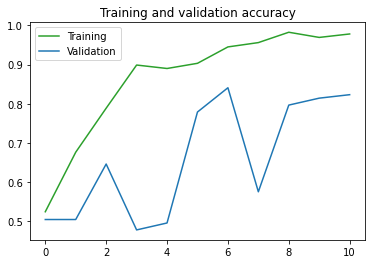

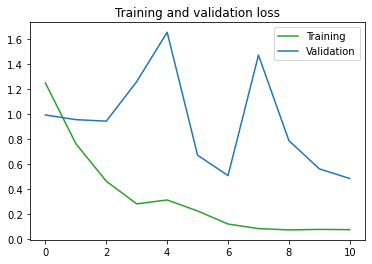

In [10]:
learning_curves(history2)

## **Test**

In [11]:
model2.load_weights("/content/drive/MyDrive/LabIA/Best Model/best_svm_model.h5")
results2 = model2.evaluate(
      test_generator,
      batch_size=batch_dim)
print("test loss, test acc:", results2)

23/23 [==============================] - 19s 535ms/step - loss: 0.7970 - acc: 0.7833
test loss, test acc: [0.7970024943351746, 0.7833333611488342]


# **ResNet50V2**

## **Model**

### **Pre-Model**

In [7]:
pre_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(256, 256, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        classes=2,
                                                        pooling='avg')
pre_model.trainable = False

94683136/94668760 [==============================] - 1s 0us/step


### **Total Model**

In [8]:
i_input = layers.Input(shape=(256, 256, 3))
x = tf.keras.applications.resnet_v2.preprocess_input(i_input)
x = pre_model(x,training=False)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation = 'relu')(x)

output = layers.Dense(1, activation='sigmoid')(x)

res_model = Model(i_input, output)

res_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192  

## **Compilazione**

In [9]:
lr=0.001

res_model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=lr),
              metrics=['acc'])

## **Train**

In [10]:
epoche=50
es=EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)
mc=ModelCheckpoint('/content/drive/MyDrive/LabIA/Best Model/best_res_model.h5', monitor='val_accuracy', mode='max')

with tf.device('/gpu:0'):
  history_res = res_model.fit(
        train_generator,
        epochs=epoche,
        validation_data=validation_generator,
        callbacks=[mc,es])

Epoch 1/50
57/57 [==============================] - 58s 289ms/step - loss: 0.6797 - acc: 0.6850 - val_loss: 0.6256 - val_acc: 0.6372
Epoch 2/50
57/57 [==============================] - 4s 71ms/step - loss: 0.2813 - acc: 0.8789 - val_loss: 0.4660 - val_acc: 0.8142
Epoch 3/50
57/57 [==============================] - 3s 60ms/step - loss: 0.1503 - acc: 0.9361 - val_loss: 0.4999 - val_acc: 0.8053
Epoch 4/50
57/57 [==============================] - 3s 60ms/step - loss: 0.1001 - acc: 0.9626 - val_loss: 0.4862 - val_acc: 0.7876
Epoch 5/50
57/57 [==============================] - 3s 61ms/step - loss: 0.0748 - acc: 0.9670 - val_loss: 0.3947 - val_acc: 0.8761
Epoch 6/50
57/57 [==============================] - 3s 59ms/step - loss: 0.0556 - acc: 0.9780 - val_loss: 0.4744 - val_acc: 0.8142
Epoch 7/50
57/57 [==============================] - 4s 64ms/step - loss: 0.0801 - acc: 0.9824 - val_loss: 0.5380 - val_acc: 0.8230
Epoch 8/50
57/57 [==============================] - 3s 59ms/step - loss: 0.0339 -

### **Disegno Learning Curves**

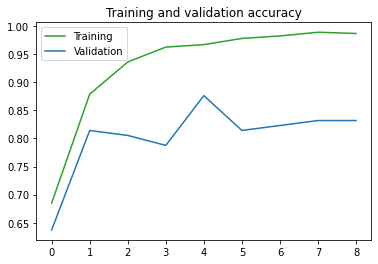

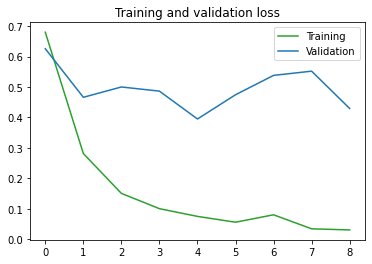

In [11]:
learning_curves(history_res)

## **Test**

In [12]:
res_model.load_weights("/content/drive/MyDrive/LabIA/Best Model/best_res_model.h5")
results_res = res_model.evaluate(
      test_generator,
      batch_size=batch_dim)
print("test loss, test acc:", results_res)

23/23 [==============================] - 24s 640ms/step - loss: 1.4007 - acc: 0.6833
test loss, test acc: [1.4007015228271484, 0.6833333373069763]
